<a href="https://colab.research.google.com/github/aneeshcheriank/Advanced-vision/blob/main/Selective_search_to_generate_region_proposals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q selectivesearch
!pip install -q torch_snippets

from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb
from google.colab import files

In [13]:
file_names = files.upload()
for file in file_names.keys():
  img = read(file, 1)
  break

def extract_candidates(img):
  img_lbl, regions = selectivesearch.selective_search(
    img, scale=200, min_size=100
  )
  # we are considering only those regions with 5% of 
  # total image area and less than or equal to 100% of 
  # the image area and return them
  img_area = np.prod(img.shape[:2])
  candidates = []

  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05*img_area): continue
    if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    # why the list is unpacked here?
    candidates.append(list(r['rect']))
  return candidates

Saving images (2).jpeg to images (2).jpeg


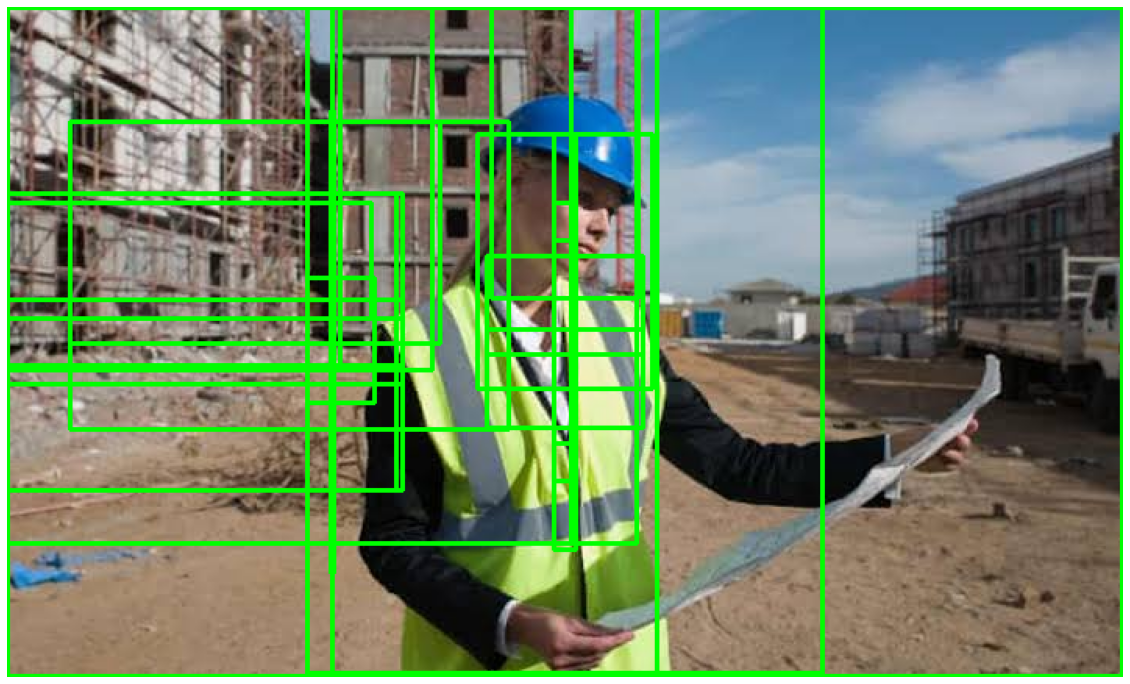

In [14]:
candidates = extract_candidates(img)
show(img, bbs=candidates)

## Background and Object
- the bounding box has a high IOU with ground truth is labelled as the box with object
- Low intersection is labelled as backgound

## IOU
- intersection over union (IOU)
  - iou = <sup>overlapping region</sup>/<sub>combined region</sub>
  - if there is a higerh overlap IOU will be closer to 1

In [16]:
def get_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = max(boxA[2], boxB[2])
  y2 = max(boxA[3], boxB[3])

  # intersection area
  width = x2-x1
  height = y2-y1
  if (width<0) or (height<0):
    return 0.0

  area_overlap = height*width

  # combined area
  area_a = (boxA[2] - boxA[0])*(boxA[3]-boxA[1])
  area_b = (boxB[2] - boxB[0])*(boxB[3]-boxB[1])
  combined_area = area_a+area_b
  
  iou = area_overlap / (area_combined+epsilon)
  return iou

## Non-max suppression
- Non-max: the box don't contain the highest probability of an object
- Suppression: remove those non-max boxes

<i>
- Pytorch has an inbuilt function to perform this
<br>
- nms function in the torchvision.ops module
</i>

 ## Mean average precision
- prediction accuracy of the model
- precision = <sup>True positives</sup>/<sub>(True positives + False positives)</sub>

  - True positive
    - bouding box predict correct class of objects
    - IOU with the ground truth is greater than a certain threshold

  - False positive
    - predicted class is incorrect
    - or IOU is less than a threshold with the ground truth
    - (one more condition) if there are multiple bouding boxes for same ground truth box, only one box can get into a true positive, and everything else get into a false positive

- <b>Average Precision</b>: average fo precision values calculated at varioous IoU thresholds
- <b></b> average of precision values calculated at various IoU threshold values accross all the classes of objects present within the dataset

# Traning R-CNN based custom object detectors
- R-CNN: Region-based Convolutional Neural Network
- Steps
  - Extract region proposals
  - resize (wrap) image
  - pass the region proposal through the network
    - pretrained network